# Metrics in Keras

In this reading we will be exploring the different metrics in Keras that may be used to judge the performance of a model.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow.keras.backend as K
print(tf.__version__)

2.0.0


One of the most common metrics used for classification problems in Keras is `'accuracy'`. 

We will begin with a simple example of a model that uses accuracy as a metric.

In [2]:
# Build the model
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(32, activation='relu'),
  Dense(32, activation='tanh'),
  Dense(10, activation='softmax'),
])

In [3]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

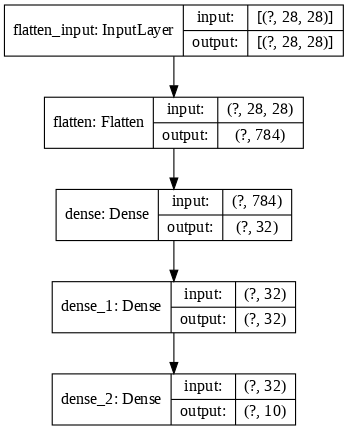

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, dpi=80)

We now have a model that uses accuracy as a metric to judge its performance.

But how is this metric actually calculated? We will break our discussion into two cases.


### Case 1 - Binary Classification with sigmoid activation function
Suppose we are training a model for a binary classification problem with a sigmoid activation function (softmax activation functions are covered in the next case). 

Given a training example with input $x^{(i)}$, the model will output a float between 0 and 1. Based on whether this float is less than or greater than our "threshold" (which by default is set at 0.5), we round the float to get the predicted classification $y_{pred}$ from the model.

The accuracy metric compares the value of $y_{pred}$ on each training example with the true output, the one-hot coded vector $y_{true}^{(i)}$ from our training data.

Let $$\delta(y_{pred}^{(i)},y_{true}^{(i)}) = \begin{cases} 1 & y_{pred}=y_{true}\\
0 & y_{pred}\neq y_{true} \end{cases}$$

The accuracy metric  computes the mean of $\delta(y_{pred}^{(i)},y_{true}^{(i)})$ over all training examples.

$$ accuracy = \frac{1}{N} \sum_{i=1}^N \delta(y_{pred}^{(i)},y_{true}^{(i)}) $$

This is implemented in the backend of Keras as follows. 
Note: We have set $y_{true}$ and $y_{pred}$ ourselves for the purposes of this example.

In [5]:
# Sigmoid activation function
y_true = tf.constant([0.0, 1.0, 1.0])
y_pred = tf.constant([0.4, 0.8, 0.3])
accuracy = K.mean(K.equal(y_true, K.round(y_pred)))
accuracy

<tf.Tensor: id=174, shape=(), dtype=float32, numpy=0.6666667>

### Case 2 - Categorical Classification
Now suppose we are training a model for a classification problem which should sort data into $m>2$ different classes using a softmax activation function in the last layer.

Given a training example with input $x^{(i)}$, the model will output a tensor of probabilities $p_1, p_2, \dots p_m$, giving the likelihood (according to the model) that $x^{(i)}$ falls into each class.

The accuracy metric works by determining the largest argument in the $y_{pred}^{(i)}$ tensor, and compares its index to the index of the maximum value of $y_{true}^{(i)}$ to determine $\delta(y_{pred}^{(i)},y_{true}^{(i)})$. It then computes the accuracy in the same way as for the binary classification case.

$$ accuracy = \frac{1}{N} \sum_{i=1}^N \delta(y_{pred}^{(i)},y_{true}^{(i)}) $$

In the backend of Keras, the accuracy metric is implemented slightly differently depending on whether we have a binary classification problem ($m=2$) or a categorical classifcation problem. Note that the accuracy for binary classification problems is the same, no matter if we use a sigmoid or softmax activation function to obtain the output.


In [6]:
# Binary classification with softmax
y_true = tf.constant([[0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
y_pred = tf.constant([[0.4, 0.6], [0.3, 0.7], [0.05, 0.95], [0.33, 0.67]])
accuracy = K.mean(K.equal(y_true, K.round(y_pred)))
accuracy

<tf.Tensor: id=181, shape=(), dtype=float32, numpy=0.5>

In [7]:
# Categorical classification with m>2
y_true = tf.constant([[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
y_pred = tf.constant([[0.4, 0.6, 0.0, 0.0], [0.3, 0.2, 0.1, 0.4], [0.05, 0.35, 0.5, 0.1]])
accuracy = K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))
accuracy

<tf.Tensor: id=191, shape=(), dtype=float32, numpy=0.6666667>

## Other examples of metrics
We will now look at some other metrics in Keras. A full list is available at <https://keras.io/metrics/>.

### Binary accuracy and categorical accuracy
The `binary_accuracy` and `categorical_accuracy` metrics are, by default, identical to the Case 1 and 2 respectively of the `accuracy` metric explained above. 

However, using `binary_accuracy` allows you to use the optional `threshold` argument, which sets the minimum value of $y_{pred}$ which will be rounded to 1. As mentioned above, it is set as `threshold=0.5` by default.

Below we give some examples of how to compile a model with `binary_accuracy` with and without a threshold.

In [8]:
# Compile the model with default threshold (=0.5)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['binary_accuracy'])

In [9]:
# The threshold can be specified as follows
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

### Sparse categorical accuracy

This is a very similar metric to categorical accuracy with one major difference - the label $y_{true}$ of each training example is not expected to be a one-hot encoded vector, but to be a tensor consisting of a single integer. This integer is then compared to the index of the maximum argument of $y_{pred}$ to determine $\delta(y_{pred}^{(i)},y_{true}^{(i)})$.

In [10]:
# Two examples of compiling a model with a sparse categorical accuracy metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["sparse_categorical_accuracy"])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### (Sparse) Top $k$-categorical accuracy 
In top $k$-categorical accuracy, instead of computing how often the model correctly predicts the label of a training example, the metric computes how often the model has $y_{true}$ in the top $k$ of its predictions. By default, $k=5$.

As before, the main difference between top $k$-categorical accuracy and its sparse version is that the former assumes $y_{true}$ is a one-hot encoded vector, whereas the sparse version assumes $y_{true}$ is an integer.

In [11]:
# Compile a model with a top-k categorical accuracy metric with default k (=5)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["top_k_categorical_accuracy"])

In [12]:
# Specify k instead with the sparse top-k categorical accuracy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

## Custom metrics
It is also possible to define your own custom metric in Keras.
You will need to make sure that your metric takes in (at least) two arguments called `y_true` and `y_pred` and then output a single tensor value.

In [13]:
# Define a custom metric
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

We can then use this metric when we compile our model as follows.

In [14]:
# Specify k instead with the sparse top-k categorical accuracy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[mean_pred])

## Multiple metrics
Finally, it is possible to use multiple metrics to judge the performance of your model. 


Here's an example:

In [15]:
# Compile the model with multiple metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[mean_pred, "accuracy",tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

### Sources and Further Reading
* The metrics page on the Keras website: https://keras.io/metrics/
* The source code for the metrics: https://github.com/keras-team/keras/blob/master/keras/metrics.py
